# SPADE LDM

In this tutorial, we apply SPADE normalisation [1] to a latent diffusion model, in a methodology initially published by Wang et al. [2] to perform semantic image synthesis. We apply to a subset of BraTS [3] that we registered to MNI space and resampled to 2mm isotropic space. Segmentations of cerebrospinal fluid, grey and white matter, deep grey matter and brainstem were obtained using Geodesic Information Flows (GIF) [4].

[1] Park, T., Liu, M.-Y., Wang, T.-C., & Zhu, J.-Y. (2019). Semantic Image Synthesis with Spatially-Adaptive Normalization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[2] Wang, W., Bao, J., Zhou, W., Chen, D., Chen, D., Yuan, L., & Li, H. (2022). Semantic Image Synthesis via Diffusion Models. https://doi.org/10.48550/arxiv.2207.00050

[3] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M.-A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694

[4] Cardoso, M. J., Wolz, R., Modat, M., Fox, N. C., Rueckert, D., & Ourselin, S. (2012). Geodesic information flows. Medical Image Computing and Computer-Assisted Intervention : MICCAI ...  International Conference on Medical Image Computing and Computer-Assisted Intervention, 15(Pt 2), 262–270. https://doi.org/10.1007/978-3-642-33418-4_33

## Setup environment 

In [5]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import gdown" || pip install -q gdown
%matplotlib inline

/bin/bash: line 1: 261882 Segmentation fault      python -c "import monai"

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


## Setup imports

In [6]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
from pathlib import Path
import zipfile
import gdown
from monai.config import print_config
from monai.utils import set_determinism
from monai.data import DataLoader
from tqdm import tqdm
import numpy as np
import monai
import torch.nn.functional as F
from monai.networks.nets import SPADEAutoencoderKL, SPADEDiffusionModelUNet, PatchDiscriminator
from monai.networks.schedulers import DDPMScheduler
from monai.losses import  PatchAdversarialLoss, PerceptualLoss
from torch.cuda.amp import GradScaler, autocast
from monai.inferers import LatentDiffusionInferer

print_config()

MONAI version: 1.4.dev2431
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 951a77d7a7737a3108afa94623a50b87d21eb4a7
MONAI __file__: /home/<username>/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 5.2.0
TorchVision version: 0.19.0+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VER

### Set deterministic training for reproducibility

In [7]:
set_determinism(42)

## Setup a data directory and download dataset

### Description of the data

The data for this notebook comes from the brain tumour segmentation challenge (BraTS) [1]. The images have been registered to MNI space using ANTsPy, and then subsampled to 2mm isotropic resolution. Geodesic Information Flows (GIF) [2] has been used to segment 5 regions: cerebrospinal fluid (CSF), grey matter (GM), white matter (WM), deep grey matter (DGM) and brainstem. Tumour sub-layers were delineated manually as part of the challenge source data. 
In this subset, we have only used one MRI modality , T1. 
Segmentations in this subset are merged and consist of the following labels: 0 (background), 1 (CSF), 2 (GM), 3 (WM), 4 (DGM), 5 (brainstem), 6 (brainstem), 7 (non GD-enahncing tumour core), 8 (peritumoural oedema), 9 (GD-enhancing tumour).

Citations:

[1] Menze, B. H., Jakab, A., Bauer, S., Kalpathy-Cramer, J., Farahani, K., Kirby, J., Burren, Y., Porz, N., Slotboom, J., Wiest, R., Lanczi, L., Gerstner, E., Weber, M. A., Arbel, T., Avants, B. B., Ayache, N., Buendia, P., Collins, D. L., Cordier, N., … van Leemput, K. (2015). The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS). IEEE Transactions on Medical Imaging, 34(10), 1993–2024. https://doi.org/10.1109/TMI.2014.2377694

[2] Cardoso MJ, Modat M, Wolz R, Melbourne A, Cash D, Rueckert D, Ourselin S. Geodesic Information Flows: Spatially-Variant Graphs and Their Application to Segmentation and Fusion. IEEE Trans Med Imaging. 2015 Sep;34(9):1976-88. doi: 10.1109/TMI.2015.2418298. Epub 2015 Apr 14. PMID: 25879909.


### Set-up a data directory

In [8]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = Path(root_dir)
print("Temporary directory used: %s " % root_dir)

Temporary directory used: /tmp/tmplv6n4dtp 


### Download data

In [9]:
# Comment if already downloaded!
gdown.download("https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m", os.path.join(root_dir, "data.zip"))
#!gdown -O data.zip "https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m" --remaining-ok

Downloading...
From (original): https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m
From (redirected): https://drive.google.com/uc?id=1q87a9euo52eoFG37shPK0G5juq20x7-m&confirm=t&uuid=7028deb0-ea3d-4e3a-a379-b2c9860b884f
To: /tmp/tmplv6n4dtp/data.zip
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26.7M/26.7M [00:00<00:00, 26.9MB/s]


'/tmp/tmplv6n4dtp/data.zip'

We extract and reorganise the data into the relevant sub-folders:

In [10]:
zip_obj = zipfile.ZipFile(os.path.join(root_dir, "data.zip"), "r")
zip_obj.extractall(root_dir)
images_T1 = root_dir / "BRATS_SUBS2_SUBSET/T1"
labels = root_dir / "BRATS_SUBS2_SUBSET/Parcellations"

## Prepare dataloaders

In [11]:
# INPUT PARAMETERS
input_shape = [128, 128]
batch_size = 4
num_workers = 2

In [12]:
# We create the data dictionaries that we need
all_images = [os.path.join(images_T1, i) for i in os.listdir(images_T1)]
np.random.shuffle(all_images)
corresponding_labels = [
    os.path.join(labels, i.split("/")[-1].replace(i.split("/")[-1].split("_")[0], "Parcellation")) for i in all_images
]
input_dict = [{"image": i, "label": corresponding_labels[ind]} for ind, i in enumerate(all_images)]
input_dict_train = input_dict[: int(len(input_dict) * 0.9)]
input_dict_val = input_dict[int(len(input_dict) * 0.9) :]

We define the relevant transforms:

In [13]:
preliminar_shape = input_shape + [50]  # We take random slices fron the center of the brain
crop_shape = input_shape + [1]
base_transforms = [
    monai.transforms.LoadImaged(keys=["label", "image"]),
    monai.transforms.EnsureChannelFirstd(keys=["image", "label"]),
    monai.transforms.CenterSpatialCropd(keys=["label", "image"], roi_size=preliminar_shape),
    monai.transforms.RandSpatialCropd(keys=["label", "image"], roi_size=crop_shape, max_roi_size=crop_shape),
    monai.transforms.SqueezeDimd(keys=["label", "image"], dim=-1),
    monai.transforms.Resized(keys=["image", "label"], spatial_size=input_shape),
]
last_transforms = [
    monai.transforms.CopyItemsd(keys=["label"], names=["label_channel"]),
    monai.transforms.Lambdad(keys=["label_channel"], func=lambda l: l != 0),
    monai.transforms.MaskIntensityd(keys=["image"], mask_key="label_channel"),
    monai.transforms.NormalizeIntensityd(keys=["image"]),
    monai.transforms.ToTensord(keys=["image", "label"]),
]

aug_transforms = [
    monai.transforms.RandBiasFieldd(coeff_range=(0, 0.005), prob=0.33, keys=["image"]),
    monai.transforms.RandAdjustContrastd(gamma=(0.9, 1.15), prob=0.33, keys=["image"]),
    monai.transforms.RandGaussianNoised(prob=0.33, mean=0.0, std=np.random.uniform(0.005, 0.015), keys=["image"]),
    monai.transforms.RandAffined(
        rotate_range=[-0.05, 0.05],
        shear_range=[0.001, 0.05],
        scale_range=[0, 0.05],
        padding_mode="zeros",
        mode="nearest",
        prob=0.33,
        keys=["label", "image"],
    ),
]

We create the dataset and dataloader:

In [14]:
train_transforms = monai.transforms.Compose(base_transforms + aug_transforms + last_transforms)
val_transforms = monai.transforms.Compose(base_transforms + last_transforms)

train_dataset = monai.data.dataset.Dataset(input_dict_train, train_transforms)
val_dataset = monai.data.dataset.Dataset(input_dict_val, val_transforms)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=num_workers)

We do a sanity check and plot an element of the dataset:

torch.Size([4, 1, 128, 128])


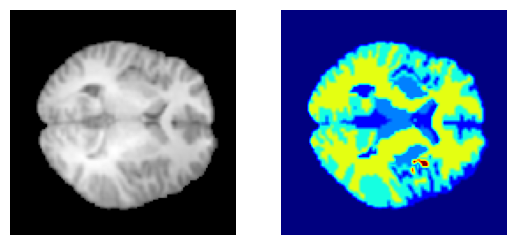

In [15]:
# Sanity check
batch = next(iter(train_loader))
print(batch["image"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["image"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["label"][0, 0, ...], cmap="jet")
plt.axis("off")
plt.show()

### Networks creation and losses

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [17]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [18]:
def picture_results(input_label, input_image, output_image):
    f = plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Label")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

SPADE Diffusion Models require two components:
- Autoencoder, incorporating SPADE normalisation in the decoder blocks
- Diffusion model, operating in the latent space, and incorporating SPADE normalisation in the decoding branch

In [19]:
autoencoder = SPADEAutoencoderKL(spatial_dims = 2, in_channels = 1, out_channels = 1,
                           num_res_blocks = (2,2,2,2), channels = (8, 16, 32, 64),
                           attention_levels = [False, False, False, False],
                           latent_channels = 8, norm_num_groups = 8, label_nc = 6
                           )

In [20]:
diffusion = SPADEDiffusionModelUNet(spatial_dims = 2, in_channels = 8, out_channels = 8,
                              num_res_blocks = (2,2,2,2), channels = (16, 32, 64, 128),
                              attention_levels = (False, False, True, True), norm_num_groups = 16,
                              with_conditioning = False, label_nc = 6)

To train the autoencoder, we are using **a Patch-GAN-based adversarial loss**, a **perceptual loss** and a basic **L1 loss** between input and output.

In [21]:
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)

/home/vf19/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vf19/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/vf19/PycharmProjects/MONAI_tutorials/venv/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will e

PerceptualLoss(
  (perceptual_function): LPIPS(
    (scaling_layer): ScalingLayer()
    (net): alexnet(
      (slice1): Sequential(
        (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        (1): ReLU(inplace=True)
      )
      (slice2): Sequential(
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (4): ReLU(inplace=True)
      )
      (slice3): Sequential(
        (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU(inplace=True)
      )
      (slice4): Sequential(
        (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU(inplace=True)
      )
      (slice5): Sequential(
        (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): Re

In [22]:
discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, channels=16, in_channels=1, out_channels=1,
                                  )
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [23]:
recon = torch.nn.L1Loss()

In [24]:
optimizer_G = torch.optim.Adam(autoencoder.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0004)
# For mixed precision training
scaler_g = torch.amp.GradScaler()
scaler_d = torch.amp.GradScaler()

## Training the AutoencoderKL

We used the exact same approach as the one from the 2d_ldm_tutorial to train the autoencoder.

In [25]:
## Loss weights and number of epochs
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
adv_weights = 0.01
autoencoder_warm_up_n_epochs = 10
perceptual_weight = 0.001

Epoch 0:   0%|                                                                          | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_261835/3454159266.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 9: 100%|██████████████████████| 6/6 [00:00<00:00,  7.23it/s, recons_loss=0.104, gen_loss=0, disc_loss=0]
/tmp/ipykernel_261835/3454159266.py:78: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


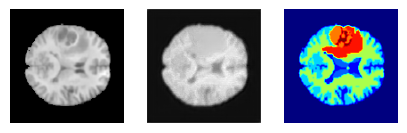

epoch 10 val loss: 0.0939


Epoch 11:   0%|                                                                         | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_261835/3454159266.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 19: 100%|████████████| 6/6 [00:00<00:00,  7.17it/s, recons_loss=0.0781, gen_loss=0.261, disc_loss=0.252]


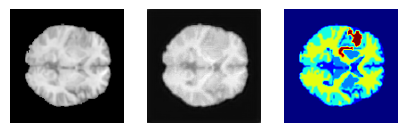

epoch 20 val loss: 0.0655


Epoch 29: 100%|████████████| 6/6 [00:00<00:00,  7.29it/s, recons_loss=0.0593, gen_loss=0.256, disc_loss=0.249]


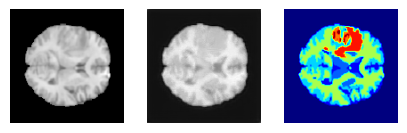

epoch 30 val loss: 0.0592


Epoch 39: 100%|████████████| 6/6 [00:00<00:00,  7.14it/s, recons_loss=0.0544, gen_loss=0.274, disc_loss=0.251]


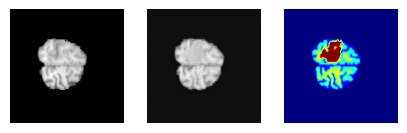

epoch 40 val loss: 0.0407


Epoch 49: 100%|████████████| 6/6 [00:00<00:00,  7.24it/s, recons_loss=0.0504, gen_loss=0.259, disc_loss=0.247]


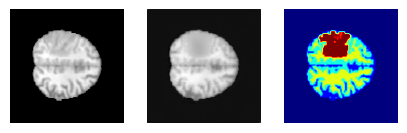

epoch 50 val loss: 0.0427


Epoch 59: 100%|████████████| 6/6 [00:00<00:00,  7.02it/s, recons_loss=0.0474, gen_loss=0.274, disc_loss=0.249]


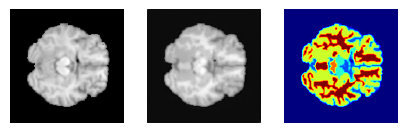

epoch 60 val loss: 0.0495


Epoch 69: 100%|████████████| 6/6 [00:00<00:00,  6.89it/s, recons_loss=0.0454, gen_loss=0.303, disc_loss=0.256]


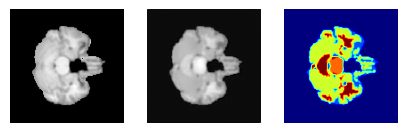

epoch 70 val loss: 0.0428


Epoch 79: 100%|█████████████| 6/6 [00:00<00:00,  7.23it/s, recons_loss=0.0445, gen_loss=0.302, disc_loss=0.25]


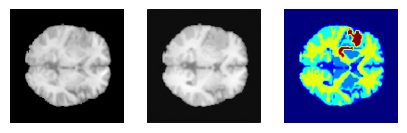

epoch 80 val loss: 0.0399


Epoch 89: 100%|████████████| 6/6 [00:00<00:00,  7.49it/s, recons_loss=0.0401, gen_loss=0.291, disc_loss=0.233]


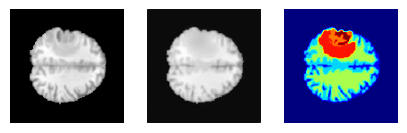

epoch 90 val loss: 0.0348


Epoch 99: 100%|█████████████| 6/6 [00:00<00:00,  7.11it/s, recons_loss=0.0454, gen_loss=0.26, disc_loss=0.243]


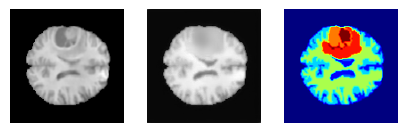

epoch 100 val loss: 0.0448


In [26]:
autoencoder.to(device)

# Loss storage
epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []

for epoch in range(n_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        labels = one_hot(batch['label'], 6).to(device)
        optimizer_G.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoder(images, labels)
            recons_loss = recon(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_G)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_D.zero_grad(set_to_none=True)
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_D)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )

    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=0):
                images = batch["image"].to(device)
                labels = one_hot(batch['label'], 6).to(device)
                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoder(images, labels)
                    recons_loss = recon(images.float(), reconstruction.float())
                val_loss += recons_loss.item()
                # We retrieve the image to plot
                if val_step == 0:
                    reconstruction = reconstruction.detach().cpu()
                    plt.figure(figsize=(5,3))
                    plt.subplot(1, 3, 1)
                    plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
                    plt.axis("off")
                    plt.subplot(1, 3, 2)
                    plt.imshow(reconstruction[0, 0, ...], cmap = "gist_gray")
                    plt.axis('off')
                    plt.subplot(1, 3, 3)
                    plt.imshow(batch["label"][0, 0, ...].detach().cpu(), cmap="jet")
                    plt.axis("off")
                    plt.show()


        val_loss /= max(val_step, 1)
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

## Training the diffusion model

Likewise, we use the same approach as in the 2d_ldm_tutorial.

In [27]:
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
inferer = LatentDiffusionInferer(scheduler, scale_factor=1.0)

/tmp/ipykernel_261835/3280443412.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:   0%|                                  | 0/6 [00:00<?, ?it/s]/tmp/ipykernel_261835/3280443412.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 39: 100%|█████████████| 6/6 [00:01<00:00,  5.60it/s, loss=0.769]
/tmp/ipykernel_261835/3280443412.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipykernel_261835/3280443412.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 39 val loss: 0.7233


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.90it/s]


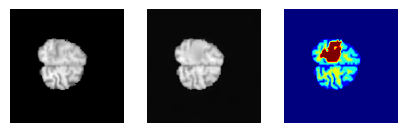

Epoch 79: 100%|█████████████| 6/6 [00:01<00:00,  5.77it/s, loss=0.626]


Epoch 79 val loss: 0.6996


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.44it/s]


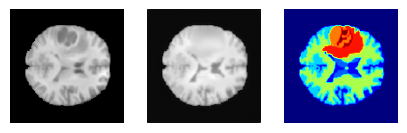

Epoch 119: 100%|█████████████| 6/6 [00:01<00:00,  5.10it/s, loss=0.48]


Epoch 119 val loss: 0.4349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.09it/s]


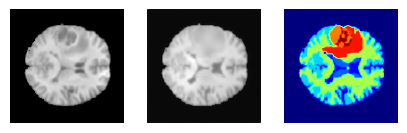

Epoch 159: 100%|████████████| 6/6 [00:01<00:00,  5.62it/s, loss=0.354]


Epoch 159 val loss: 0.3508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.22it/s]


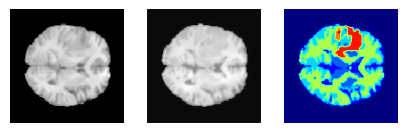

Epoch 199: 100%|████████████| 6/6 [00:01<00:00,  5.71it/s, loss=0.391]


Epoch 199 val loss: 0.2205


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.03it/s]


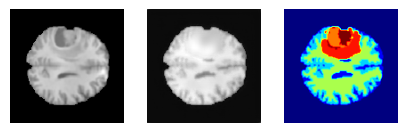

In [28]:
diffusion = diffusion.to(device)
n_epochs = 200
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()

for epoch in range(n_epochs):
    diffusion.train()
    autoencoder.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        labels = one_hot(batch["label"], 6).to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoder.encode(images)
            z = autoencoder.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=diffusion, noise=noise, timesteps=timesteps, autoencoder_model=autoencoder,
                seg = labels
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        diffusion.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)
                labels = one_hot(batch["label"], 6).to(device)
                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoder.encode(images)

                    z = autoencoder.sampling(z_mu, z_sigma)
                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=diffusion,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoder,
                        seg = labels,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training. We use the last segmentation of our loader
        z = torch.randn((labels.shape[0], 8, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=diffusion, scheduler=scheduler, autoencoder_model=autoencoder,
                seg = labels)
        plt.figure(figsize=(5, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.imshow(decoded[0, 0, ...].detach().cpu(), cmap = "gist_gray")
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(batch["label"][0, 0, ...].detach().cpu(), cmap="jet")
        plt.axis("off")
        plt.show()

progress_bar.close()
